<a href="https://colab.research.google.com/github/al3jandroR/nba_predictions/blob/colab/nba_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [405]:
!pip install nba_api

In [406]:
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.static import teams
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from nba_api.stats.endpoints import scoreboardv2
from datetime import datetime, timedelta
from pytz import timezone
import pandas as pd
import matplotlib.pyplot as plt
import time

In [407]:
nba_teams = teams.get_teams()
teams_df = pd.DataFrame(nba_teams)

In [408]:
# Helper function to avoid api rate limits
def safe_request(func, *args, **kwargs):
    while True:
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"Error: {e}. Retrying in 5 seconds...")
            time.sleep(5)

def get_team_id(abbr):
    team = teams_df[teams_df['abbreviation'] == abbr.upper()]
    if not team.empty:
        return team.iloc[0]['id']
    else:
        raise ValueError(f"Team abbreviation '{abbr}' not found.")

def get_team_abbr(team_id):
    team = teams_df[teams_df['id'] == team_id]
    if not team.empty:
        return team.iloc[0]['abbreviation']
    else:
        raise ValueError(f"No team found for ID: {team_id}")

def get_team_stats(team_id, season, n=5):
    log = safe_request(teamgamelog.TeamGameLog, team_id=team_id, season=season)
    df = log.get_data_frames()[0]

    df = df[['GAME_DATE', 'MATCHUP', 'WL', 'PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']].copy()

    df['SEASON'] = season
    df['HOME'] = df['MATCHUP'].str.contains('vs.').astype(int)
    df['WIN'] = df['WL'].apply(lambda x: 1 if x == 'W' else 0)
    df['STREAK'] = df['WIN'].rolling(window=n).sum().shift(-1).fillna(0)

    # avg stats from last 5 games
    rolling_features = ['PTS', 'OREB', 'DREB', 'FG_PCT', 'AST', 'TOV', 'STL', 'BLK']
    for col in rolling_features:
        df[f'{col}_AVG'] = df[col].rolling(window=n).mean().shift(-1)

    df['DEFENSE_SCORE'] = df['STL_AVG'] + df['BLK_AVG'] + df['DREB_AVG']
    df['AST_TOV_RATIO'] = df['AST_AVG'] / (df['TOV_AVG'] + 1)
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format='%b %d, %Y')
    df['EFFICIENCY'] = df['FG_PCT_AVG'] * df['PTS_AVG']
    df['PREV_GAME_DATE'] = df['GAME_DATE'].shift(-1)
    df['DAYS_REST'] = (df['GAME_DATE'] - df['PREV_GAME_DATE']).dt.days.clip(lower=0)
    df['BACK_TO_BACK'] = (df['GAME_DATE'] - df['PREV_GAME_DATE']).dt.days.eq(1).astype(int)
    df['B2B_ROAD'] = (df['BACK_TO_BACK'] == 1) & (df['HOME'] == 0).astype(int)

    df = df.dropna().reset_index(drop=True)
    return df

In [409]:
all_team_dfs = []
seasons = ['2023-24', '2024-25']
for season in seasons:
  for team in nba_teams:
      try:
          print(f"Loading {team['full_name']} - {season}...")
          team_data = get_team_stats(team['id'], season)
          team_data['Team'] = team['full_name']
          all_team_dfs.append(team_data)
          time.sleep(1.5)
      except Exception as e:
          print(f"Skipping {team['full_name']} due to error")

Loading Atlanta Hawks - 2023-24...
Loading Boston Celtics - 2023-24...
Loading Cleveland Cavaliers - 2023-24...
Loading New Orleans Pelicans - 2023-24...
Loading Chicago Bulls - 2023-24...
Loading Dallas Mavericks - 2023-24...
Loading Denver Nuggets - 2023-24...
Loading Golden State Warriors - 2023-24...
Loading Houston Rockets - 2023-24...
Loading Los Angeles Clippers - 2023-24...
Loading Los Angeles Lakers - 2023-24...
Loading Miami Heat - 2023-24...
Loading Milwaukee Bucks - 2023-24...
Loading Minnesota Timberwolves - 2023-24...
Loading Brooklyn Nets - 2023-24...
Loading New York Knicks - 2023-24...
Loading Orlando Magic - 2023-24...
Loading Indiana Pacers - 2023-24...
Loading Philadelphia 76ers - 2023-24...
Loading Phoenix Suns - 2023-24...
Loading Portland Trail Blazers - 2023-24...
Loading Sacramento Kings - 2023-24...
Loading San Antonio Spurs - 2023-24...
Loading Oklahoma City Thunder - 2023-24...
Loading Toronto Raptors - 2023-24...
Loading Utah Jazz - 2023-24...
Loading Memph

In [449]:
df = pd.concat(all_team_dfs).reset_index(drop=True)
features = ['AST_TOV_RATIO', 'DEFENSE_SCORE', 'EFFICIENCY', 'FG_PCT_AVG', 'PTS_AVG', 'HOME', 'B2B_ROAD', 'DAYS_REST', 'BACK_TO_BACK', 'STREAK']
X = df[features]
y = df['WIN']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [417]:
best_model = None
best_score = 0

rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)
print("Best Random Forest score:", rf_grid.best_score_)
if rf_grid.best_score_ > best_score:
    best_score = rf_grid.best_score_
    best_model = rf_grid.best_estimator_

gb_param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=3, scoring='accuracy')
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting params:", gb_grid.best_params_)
print("Best Gradient Boosting score:", gb_grid.best_score_)
if gb_grid.best_score_ > best_score:
    best_score = gb_grid.best_score_
    best_model = gb_grid.best_estimator_

Best Random Forest params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best Random Forest score: 0.7070876068864501
Best Gradient Boosting params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting score: 0.7111500099933593


Model Accuracy: 0.73
Train Accuracy: 0.73
Test Accuracy:  0.73


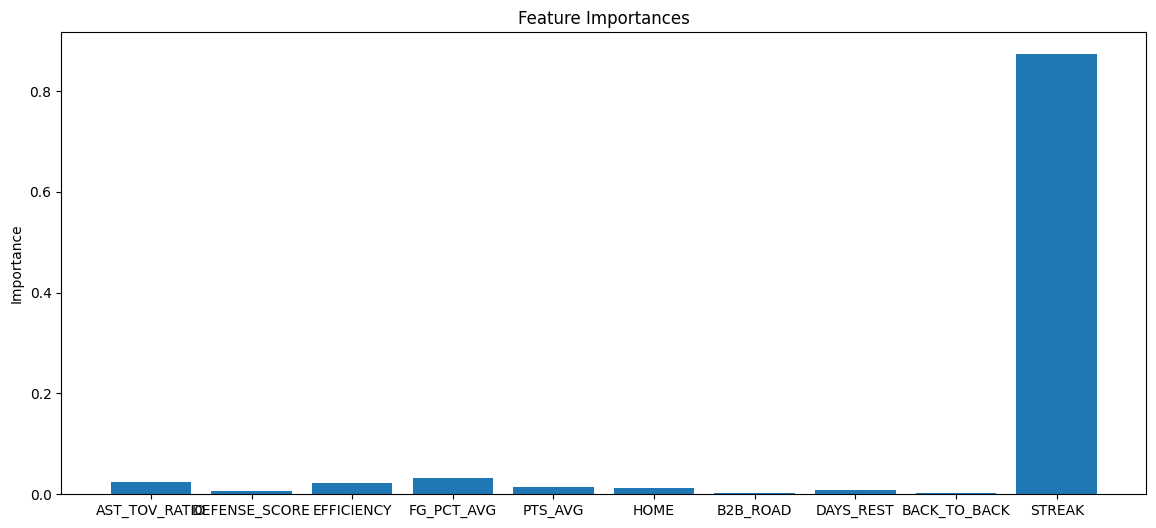

Feature Comparison (F-test vs Model Importance):
Feature                 F-Score     Model Importance
AST_TOV_RATIO            117.53               0.0244
DEFENSE_SCORE            192.72               0.0072
EFFICIENCY               274.69               0.0217
FG_PCT_AVG               207.45               0.0318
PTS_AVG                  269.25               0.0147
HOME                      17.65               0.0123
B2B_ROAD                  12.20               0.0021
DAYS_REST                  4.60               0.0091
BACK_TO_BACK               9.92               0.0034
STREAK                  1132.97               0.8732


In [450]:
clf = best_model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy:  {test_acc:.2f}")

importances = clf.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(features, importances)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)
f_scores = selector.scores_

print("Feature Comparison (F-test vs Model Importance):")
print("{:<20s} {:>10s} {:>20s}".format("Feature", "F-Score", "Model Importance"))
for name, f, imp in zip(X_train.columns, f_scores, importances):
    print(f"{name:<20s} {f:10.2f} {imp:20.4f}")

Win rates by BACK_TO_BACK status:
BACK_TO_BACK
0    0.513154
1    0.438662
Name: WIN, dtype: float64


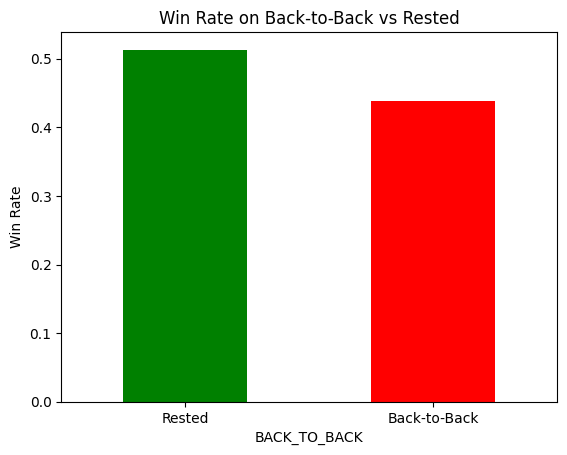

In [433]:
b2b_grouped = df.groupby('BACK_TO_BACK')['WIN'].mean()
print("Win rates by BACK_TO_BACK status:")
print(b2b_grouped)

b2b_grouped.plot(kind='bar', color=['green', 'red'], title='Win Rate on Back-to-Back vs Rested')
plt.xticks([0, 1], ['Rested', 'Back-to-Back'], rotation=0)
plt.ylabel('Win Rate')
plt.show()

b2b_penalty_ratio = b2b_grouped[1] / b2b_grouped[0]

In [435]:
#####--------RUN MODEL FOR TODAYS GAMES--------#####

today = datetime.now(timezone('US/Eastern')).strftime('%Y-%m-%d')
tomorrow = (datetime.now(timezone('US/Eastern')) + timedelta(days=1)).strftime('%Y-%m-%d')
date = today

print("Fetching games for:", date, "\n")
scoreboard = scoreboardv2.ScoreboardV2(game_date=date)
games = scoreboard.get_data_frames()[0]

matchups = games[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

for _, row in matchups.iterrows():
    home_id = row['HOME_TEAM_ID']
    away_id = row['VISITOR_TEAM_ID']
    home = get_team_abbr(home_id)
    away = get_team_abbr(away_id)

    try:
        home_stats = get_team_stats(home_id, season='2024-25').head(1)[features]
        away_stats = get_team_stats(away_id, season='2024-25').head(1)[features]

        home_proba = clf.predict_proba(home_stats)[0][1]
        away_proba = clf.predict_proba(away_stats)[0][1]
        total = home_proba + away_proba
        nhome_proba = home_proba / total
        naway_proba = away_proba / total

        winner = home if home_proba > away_proba else away

        print(f"{away} @ {home} → {winner}")
        print(f"{home} win probability: {nhome_proba:.2f} (raw: {home_proba:.2f})")
        print(f"{away} win probability: {naway_proba:.2f} (raw: {away_proba:.2f})\n")

        #total_points_estimate = home_stats[f'PTS_AVG'].values[0] + away_stats[f'PTS_AVG'].values[0]
        #print(f"Estimated total points (Over/Under baseline): {total_points_estimate:.1f}")

        #spread_estimate = abs(home_proba - away_proba) * 10
        #print(f"Estimated spread: {spread_estimate:.1f}\n")

    except Exception as e:
        print(f"Error predicting {away} @ {home}: {e}")

Fetching games for: 2025-04-08 

MEM @ CHA → MEM
CHA win probability: 0.34 (raw: 0.21)
MEM win probability: 0.66 (raw: 0.41)

CHI @ CLE → CLE
CLE win probability: 0.50 (raw: 0.57)
CHI win probability: 0.50 (raw: 0.57)

WAS @ IND → IND
IND win probability: 0.78 (raw: 0.79)
WAS win probability: 0.22 (raw: 0.23)

ATL @ ORL → ORL
ORL win probability: 0.60 (raw: 0.61)
ATL win probability: 0.40 (raw: 0.41)

NOP @ BKN → BKN
BKN win probability: 0.62 (raw: 0.40)
NOP win probability: 0.38 (raw: 0.24)

BOS @ NYK → NYK
NYK win probability: 0.50 (raw: 0.79)
BOS win probability: 0.50 (raw: 0.79)

MIN @ MIL → MIN
MIL win probability: 0.45 (raw: 0.80)
MIN win probability: 0.55 (raw: 0.96)

Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
Error: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30). Retrying in 5 seconds...
LAL @ OKC → LAL
OKC win probability: 0.43 (raw: 0.58)
LAL win probability: 0